# Тестирование полносвязной спайковой сети на MNIST

In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import matplotlib.pyplot as plt
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import time
%matplotlib inline

/usr/local/lib/python3.6/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
%run ../SNN.ipynb

In [3]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

In [4]:
input_X = T.tensor4("X")
input_shape = [None,1,28,28]
target_y = T.vector("target Y integer",dtype='int32')

In [5]:
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

dense_1 = lasagne.layers.DenseLayer(input_layer, num_units=128, 
                                    nonlinearity=lasagne.nonlinearities.rectify,
                                   name='dense_1', b=None)

dense_2 = lasagne.layers.DenseLayer(dense_1, num_units=256, 
                                    nonlinearity=lasagne.nonlinearities.sigmoid,
                                   name='dense_2', b=None)

dense_3 = lasagne.layers.DenseLayer(dense_2, num_units=64, 
                                    nonlinearity=lasagne.nonlinearities.rectify,
                                   name='dense_2', b=None)

dense_output = lasagne.layers.DenseLayer(dense_3, num_units = 10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name='output', b=None)

In [9]:
with np.load('dense_weights.npz') as f: 
    param_values = [f['arr_%d' % i] for i in range(len(f.files))] 
    for i in param_values[-1]:
        for j in i:
            j+=1
lasagne.layers.set_all_param_values(dense_output, param_values)

In [10]:
spiking_net = spiking_from_lasagne(dense_output)

In [11]:
start_time = time.time()
print(spiking_net.classify([X_train[0,0]], 20))
print(time.time() - start_time)

not_enough_time
None
306.3843550682068


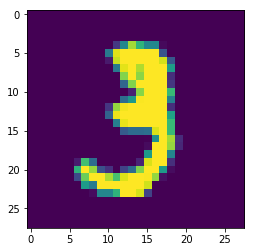

In [9]:
plt.imshow(X_train[10,0])

In [12]:
param_values[-1]

array([[-0.93213972,  0.21201617, -0.62379814, -0.05858325,  0.15017101,
         0.66350305,  0.20271201,  0.09026936,  0.13426812, -0.37216469],
       [ 0.27358601, -0.4932349 ,  0.32762183,  0.09578047, -0.0071837 ,
        -1.05673284, -0.23841489,  0.03805826, -0.41706287,  0.37560377],
       [-0.43473761,  0.37152106,  0.2634292 , -0.07721472,  0.23698381,
        -0.96037587, -0.19225774, -0.13939112,  0.24913074, -0.85630882],
       [-0.06579647,  0.89533382, -0.46734869, -0.16061454,  0.2564545 ,
        -0.73277398, -0.13159469, -0.03735012, -0.29896084, -0.3371703 ],
       [ 0.2835836 , -0.57433887,  0.26897026, -0.41025049, -0.47264082,
        -0.40333017,  0.4097305 , -0.77468592,  0.32716425,  0.03976505],
       [-0.6259008 ,  0.59796733,  0.0858437 ,  0.36390053,  0.52078045,
        -0.12545621, -0.14613437,  0.16602344, -0.69852102, -0.98478839],
       [ 0.30162538, -0.46108949, -0.6831132 , -0.16427328,  0.6392714 ,
        -0.04671163,  0.17029674, -0.61642626